<a href="https://colab.research.google.com/github/eman-abc/HAR/blob/main/edgeharnet_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.utils import to_categorical

np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RAW_PATH = "/content/drive/MyDrive/HAR/WISDM_ar_v1.1_raw.txt"  # <-- change this
assert os.path.exists(RAW_PATH), f"File not found: {RAW_PATH}"
print("Found raw file:", RAW_PATH)


Found raw file: /content/drive/MyDrive/HAR/WISDM_ar_v1.1_raw.txt


In [ ]:
def load_wisdm_raw(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # remove trailing semicolon
            if line.endswith(";"):
                line = line[:-1]
            parts = line.split(",")
            if len(parts) != 6:
                continue
            user, act, ts, x, y, z = parts
            try:
                rows.append([int(user), act.strip(), int(ts), float(x), float(y), float(z)])
            except:
                continue
    df = pd.DataFrame(rows, columns=["user","activity","timestamp","x","y","z"])
    return df

df = load_wisdm_raw(RAW_PATH)
df.head(), df.shape


(   user activity       timestamp         x          y         z
 0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
 1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
 2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
 3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
 4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164,
 (1086465, 6))

In [ ]:
TARGET_CLASSES = ["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"]
df = df[df["activity"].isin(TARGET_CLASSES)].copy()
df["activity"].value_counts()


,count
activity,
Walking,418393
Jogging,336445
Upstairs,122869
Downstairs,100425
Sitting,59939
Standing,48394


In [ ]:
def zscore_per_axis(df):
    out = df.copy()
    for c in ["x","y","z"]:
        mu = out[c].mean()
        sd = out[c].std() + 1e-8
        out[c] = (out[c] - mu) / sd
    return out

df = zscore_per_axis(df)


In [ ]:
WINDOW = 128
STEP = 32

label_map = {name:i for i, name in enumerate(TARGET_CLASSES)}

def make_windows(df, window=128, step=32):
    X, y = [], []
    # segment per user, per activity
    for (user, act), g in df.groupby(["user","activity"]):
        g = g.sort_values("timestamp")
        sig = g[["x","y","z"]].values.astype(np.float32)
        lab = label_map[act]
        for start in range(0, len(sig) - window + 1, step):
            chunk = sig[start:start+window]  # (128,3)
            X.append(chunk)
            y.append(lab)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

X, y = make_windows(df, WINDOW, STEP)
print("X:", X.shape, "y:", y.shape)
print("Class counts:", np.bincount(y))


X: (33329, 128, 3) y: (33329,)
Class counts: [12947 10402  3729  3027  1794  1430]


In [ ]:
y_oh = to_categorical(y, num_classes=6)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_oh, test_size=0.30, stratify=y, random_state=42
)

y_temp_int = np.argmax(y_temp, axis=1)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp_int, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (23330, 128, 3) (23330, 6)
Val  : (4999, 128, 3) (4999, 6)
Test : (5000, 128, 3) (5000, 6)


In [ ]:
def build_edgeharnet():
    inp = tf.keras.Input(shape=(128, 3))

    # 1x1 conv before each branch
    b1 = tf.keras.layers.Conv1D(10, 1, padding="same", activation="relu")(inp)
    b1 = tf.keras.layers.Conv1D(10, 3, padding="same", activation="relu")(b1)

    b2 = tf.keras.layers.Conv1D(10, 1, padding="same", activation="relu")(inp)
    b2 = tf.keras.layers.Conv1D(10, 5, padding="same", activation="relu")(b2)

    b3 = tf.keras.layers.Conv1D(10, 1, padding="same", activation="relu")(inp)
    b3 = tf.keras.layers.Conv1D(10, 7, padding="same", activation="relu")(b3)

    x = tf.keras.layers.Concatenate()([b1, b2, b3])  # (128, 30)

    # "9, 1x1 conv kernels are applied"
    x = tf.keras.layers.Conv1D(9, 1, padding="same", activation="relu")(x)

    # "reduce kernels to number of classes (6)"
    x = tf.keras.layers.Conv1D(6, 1, padding="same", activation="relu")(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    out = tf.keras.layers.Dense(6, activation="softmax")(x)

    m = tf.keras.Model(inp, out, name="EdgeHARNet")
    return m

model = build_edgeharnet()
model.summary()
print("Trainable params:", model.count_params())


Model: "EdgeHARNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 128, 10)   │         40 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 10)   │         40 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 128, 10)   │         40 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 128, 10)   │        310 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 10)   │        510 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 128, 10)   │        710 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 30)   │          0 │ conv1d_7[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 128, 9)    │        279 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 128, 6)    │         60 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 6)         │          0 │ conv1d_13[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 6)         │         42 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,031 (7.93 KB)

 Trainable params: 2,031 (7.93 KB)

 Non-trainable params: 0 (0.00 B)

Trainable params: 2031


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=120,
    verbose=1
)


Epoch 1/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5248 - loss: 1.5157 - val_accuracy: 0.6831 - val_loss: 0.9558
Epoch 2/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7066 - loss: 0.8814 - val_accuracy: 0.7363 - val_loss: 0.7582
Epoch 3/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7411 - loss: 0.7215 - val_accuracy: 0.7407 - val_loss: 0.6638
Epoch 4/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7435 - loss: 0.6409 - val_accuracy: 0.7558 - val_loss: 0.5866
Epoch 5/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7669 - loss: 0.5600 - val_accuracy: 0.8218 - val_loss: 0.4929
Epoch 6/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8346 - loss: 0.4719 - val_accuracy: 0.8442 - val_loss: 0.4219
Epoch 7/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8582 - loss: 0.4048 - val_accuracy: 0.8642 - val_loss: 0.3792
Epoch 8/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8739 - loss: 0.3631 - val_acc

In [ ]:
probs = model.predict(X_test, batch_size=256, verbose=0)
preds = np.argmax(probs, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = np.mean(preds == y_true)
macro_f1 = f1_score(y_true, preds, average="macro")
macro_prec = precision_score(y_true, preds, average="macro")
macro_rec = recall_score(y_true, preds, average="macro")

print(f"Accuracy        : {acc*100:.3f}%")
print(f"Macro F1        : {macro_f1*100:.3f}%")
print(f"Macro Precision : {macro_prec*100:.3f}%")
print(f"Macro Recall    : {macro_rec*100:.3f}%")

print("\nPer-class report:\n")
print(classification_report(y_true, preds, target_names=TARGET_CLASSES, digits=4))

cm = confusion_matrix(y_true, preds)
print("\nConfusion matrix:\n", cm)


Accuracy        : 98.820%
Macro F1        : 98.419%
Macro Precision : 98.559%
Macro Recall    : 98.282%

Per-class report:

              precision    recall  f1-score   support

     Walking     0.9933    0.9949    0.9941      1942
     Jogging     0.9936    0.9962    0.9949      1561
    Upstairs     0.9628    0.9696    0.9662       560
  Downstairs     0.9685    0.9493    0.9588       454
     Sitting     1.0000    0.9963    0.9981       269
    Standing     0.9953    0.9907    0.9930       214

    accuracy                         0.9882      5000
   macro avg     0.9856    0.9828    0.9842      5000
weighted avg     0.9882    0.9882    0.9882      5000


Confusion matrix:
 [[1932    3    4    3    0    0]
 [   1 1555    4    1    0    0]
 [   4    5  543    8    0    0]
 [   8    2   13  431    0    0]
 [   0    0    0    0  268    1]
 [   0    0    0    2    0  212]]


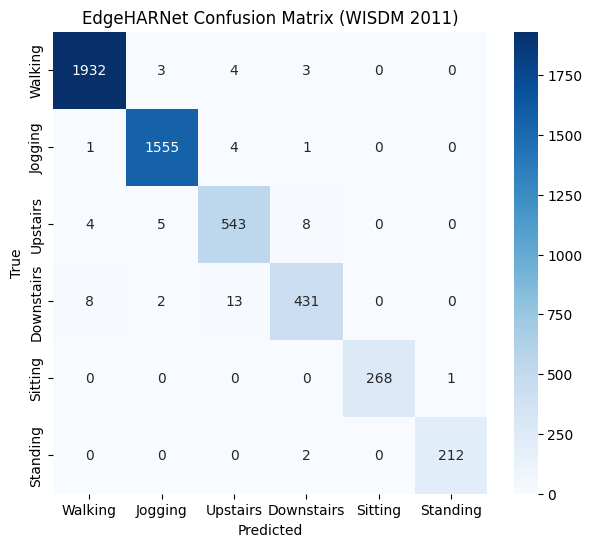

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EdgeHARNet Confusion Matrix (WISDM 2011)")
plt.show()


In [ ]:
# model.save("edgeharnet_wisdm2011.h5")
# print("Saved to edgeharnet_wisdm2011.h5")


In [ ]:
users = sorted(df["user"].unique())
print("Total users:", len(users))
print("First 10 users:", users[:10])


Total users: 36
First 10 users: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
from sklearn.model_selection import train_test_split

train_users, test_users = train_test_split(
    users,
    test_size=0.30,
    random_state=42
)

print("Train users:", len(train_users))
print("Test users :", len(test_users))


Train users: 25
Test users : 11


Segment windows per user (IMPORTANT)

This prevents leakage.

In [ ]:
WINDOW = 128
STEP = 32

def make_windows_subjectwise(df, users_subset):
    X, y = [], []

    for user in users_subset:
        df_u = df[df["user"] == user]

        for act, g in df_u.groupby("activity"):
            g = g.sort_values("timestamp")
            sig = g[["x", "y", "z"]].values.astype(np.float32)
            lab = label_map[act]

            for start in range(0, len(sig) - WINDOW + 1, STEP):
                X.append(sig[start:start+WINDOW])
                y.append(lab)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)


In [ ]:
X_train, y_train = make_windows_subjectwise(df, train_users)
X_test,  y_test  = make_windows_subjectwise(df, test_users)

print("Train windows:", X_train.shape)
print("Test windows :", X_test.shape)


Train windows: (22669, 128, 3)
Test windows : (10660, 128, 3)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train, num_classes=6)
y_test_oh  = to_categorical(y_test,  num_classes=6)


(OPTIONAL but recommended) Train-only normalization

This is strict and leakage-free. for paper faithful comment this cell out

In [ ]:
# Compute mean/std on TRAIN ONLY
mu = X_train.mean(axis=(0,1), keepdims=True)
std = X_train.std(axis=(0,1), keepdims=True) + 1e-8

X_train = (X_train - mu) / std
X_test  = (X_test  - mu) / std


In [ ]:
model = build_edgeharnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train_oh,
    epochs=150,
    batch_size=120,
    validation_split=0.15,   # validation FROM TRAIN USERS ONLY
    verbose=1
)


Epoch 1/150
161/161 [==============================] - 5s 10ms/step - loss: 1.5099 - accuracy: 0.4218 - val_loss: 1.2074 - val_accuracy: 0.5381
Epoch 2/150
161/161 [==============================] - 1s 6ms/step - loss: 1.0455 - accuracy: 0.6856 - val_loss: 0.8144 - val_accuracy: 0.7557
Epoch 3/150
161/161 [==============================] - 1s 7ms/step - loss: 0.7906 - accuracy: 0.7483 - val_loss: 0.6582 - val_accuracy: 0.7698
Epoch 4/150
161/161 [==============================] - 1s 9ms/step - loss: 0.6451 - accuracy: 0.7602 - val_loss: 0.6050 - val_accuracy: 0.7730
Epoch 5/150
161/161 [==============================] - 1s 9ms/step - loss: 0.5399 - accuracy: 0.7797 - val_loss: 0.5498 - val_accuracy: 0.7807
Epoch 6/150
161/161 [==============================] - 1s 6ms/step - loss: 0.4600 - accuracy: 0.8324 - val_loss: 0.5013 - val_accuracy: 0.8103
Epoch 7/150
161/161 [==============================] - 1s 6ms/step - loss: 0.4066 - accuracy: 0.8528 - val_loss: 0.4811 - val_accuracy: 0.820

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

probs = model.predict(X_test, batch_size=256, verbose=0)
preds = np.argmax(probs, axis=1)

acc = np.mean(preds == y_test)
macro_f1 = f1_score(y_test, preds, average="macro")
macro_prec = precision_score(y_test, preds, average="macro")
macro_rec = recall_score(y_test, preds, average="macro")

print(f"Subject-wise Accuracy        : {acc*100:.2f}%")
print(f"Subject-wise Macro F1        : {macro_f1*100:.2f}%")
print(f"Subject-wise Macro Precision : {macro_prec*100:.2f}%")
print(f"Subject-wise Macro Recall    : {macro_rec*100:.2f}%")

print("\nPer-class report:\n")
print(classification_report(y_test, preds, target_names=TARGET_CLASSES, digits=4))

cm = confusion_matrix(y_test, preds)
print("\nConfusion matrix:\n", cm)


Subject-wise Accuracy        : 81.17%
Subject-wise Macro F1        : 78.09%
Subject-wise Macro Precision : 78.51%
Subject-wise Macro Recall    : 79.14%

Per-class report:

              precision    recall  f1-score   support

     Walking     0.8960    0.8455    0.8700      4025
     Jogging     0.9758    0.8727    0.9214      3377
    Upstairs     0.5057    0.7258    0.5961      1459
  Downstairs     0.6166    0.5612    0.5876      1046
     Sitting     1.0000    0.8315    0.9080       368
    Standing     0.7163    0.9117    0.8023       385

    accuracy                         0.8117     10660
   macro avg     0.7851    0.7914    0.7809     10660
weighted avg     0.8376    0.8117    0.8199     10660


Confusion matrix:
 [[3403   16  571   17    0   18]
 [  82 2947  160  188    0    0]
 [ 131   52 1059  160    0   57]
 [ 149    5  303  587    0    2]
 [   0    0    0    0  306   62]
 [  33    0    1    0    0  351]]


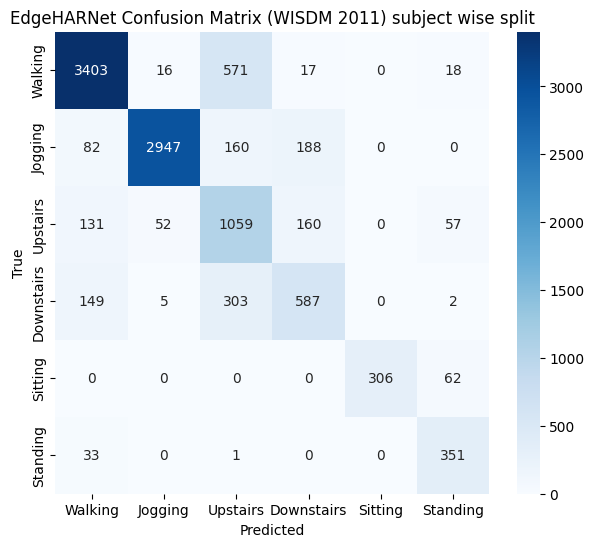

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EdgeHARNet Confusion Matrix (WISDM 2011) subject wise split")
plt.show()

| Evaluation   | EdgeHARNet | Your result |
| ------------ | ---------------- | ----------- |
| Random split | ~94%             | ~99%        |
| Subject-wise | ❌ Not reported   | **81%**     |



EdgeHARNet performs extremely well under random splits

Performance drops substantially under subject-wise (user-independent) evaluation

The biggest failures are Upstairs / Downstairs and other subtle classes

These failures are linked to limited temporal abstraction and generalization

Can knowledge distillation from a Transformer-based teacher improve the subject-wise generalization of an ultra-lightweight CNN (EdgeHARNet) for human activity recognition without increasing model complexity?